In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pylab import rcParams


In [2]:
#import seaborn as sns
#sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

In [3]:
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Select a file for the case you want to analyze
dataset = pd.read_csv("HAR-data/reference/BRJ-2022-12-1908.03.34-walking.csv", delimiter=";", decimal=",")
dataset.describe()

,time,gFx,gFy,gFz,TgF
count,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000
mean,12.394004,0.058338,0.248251,0.950766,1.022002
std,7.160298,0.091711,0.239601,0.195893,0.169300
min,0.003445,-0.163900,-0.395800,0.254300,0.540000
25%,6.193621,0.000700,0.105800,0.832800,0.910000
50%,12.392788,0.043000,0.206200,0.964800,1.012000
75%,18.591363,0.095000,0.379700,1.062500,1.114000
max,24.791285,0.682300,0.985800,1.595300,1.719000


In [5]:
# Set index of dataframe to be 'timestamp' column
dataset.set_index('time', inplace = True)
dataset.tail()

,gFx,gFy,gFz,TgF
time,,,,
24.772376,0.1148,0.0831,1.0906,1.100
24.775084,0.1124,0.0906,1.0886,1.098
24.782508,0.1116,0.0960,1.0850,1.095
24.790519,0.1129,0.1033,1.0720,1.083
24.791285,0.1119,0.1119,1.0512,1.063


## Helper functions

In [6]:
def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]
    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))
        
def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(0.5*t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(abs(similarity))

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

# Exploratory Data Analysis
## Time series of vibration data
Let's follow the tutorial https://machinelearningmastery.com/time-series-data-visualization-with-python/

In [7]:
start = dataset.index[0]
stop = dataset.index[-1]

In [8]:
dataset.columns

Index(['gFx', 'gFy', 'gFz', 'TgF'], dtype='object')

In [9]:
df_stats = dataset[['TgF']]

In [10]:
duration = dataset.index[-1] # Duration of acceleration record = last index
fs = dataset.loc[dataset.index < 1].shape[0] # Acquisition frequency = number rows in the first second
interval = (1/fs) * 1000 # Interval between consecutive points (milliseconds)

24.8 seconds serie, interval between consecutive points = 5.0 milliseconds


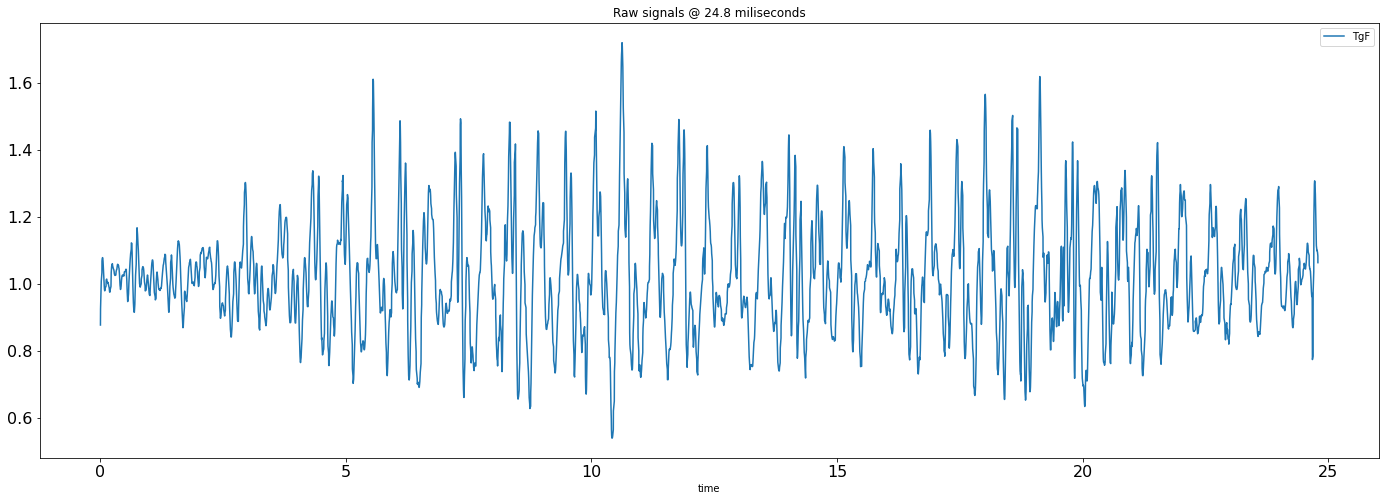

In [11]:
print("%.1f seconds serie, interval between consecutive points = %.1f milliseconds" % (duration, interval) )
rcParams['figure.figsize'] = 24, 8
df_stats.plot(title="Raw signals @ %.1f miliseconds" % duration, fontsize=16) #, marker='x')
plt.show()

## Find RR-intervals
### Peak detection using template matching & threshold
https://medium.com/orikami-blog/exploring-heart-rate-variability-using-python-483a7037c64d

In [12]:
qrs_resolution = round(fs/2)  # Number of points of the pattern function
'''
200 points/second => 100 points/0.5s => QRS filter of half second
We measure 15 steps/10s aprox. => 0.67 seg/step
So, the ideal lenght of QRS filter is the main period of the signal, i.e. time between consecutive steps
'''
threshold = 0 # For similarity after applying convolution

In [13]:
# get slice data
cond_slice = (df_stats.index >= start) & (df_stats.index < stop) 
ecg_slice = df_stats[cond_slice].TgF
t = np.linspace(0, 2 * np.pi, qrs_resolution)
qrs_filter = np.sin(0.5*t)

# detect peaks
peaks, similarity = detect_peaks(ecg_slice, threshold=threshold, qrs_filter=qrs_filter)

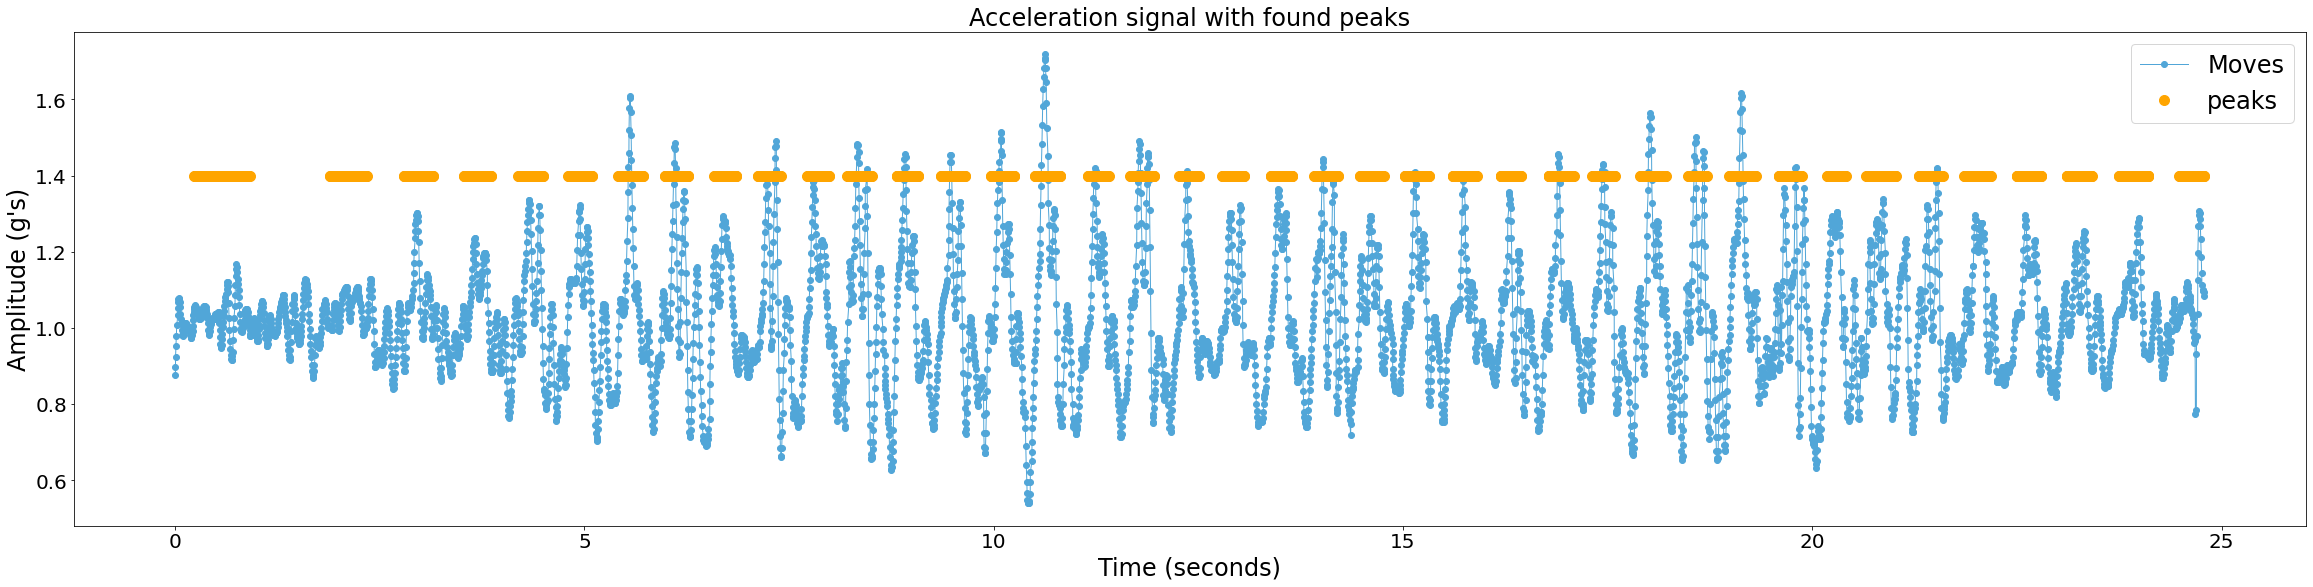

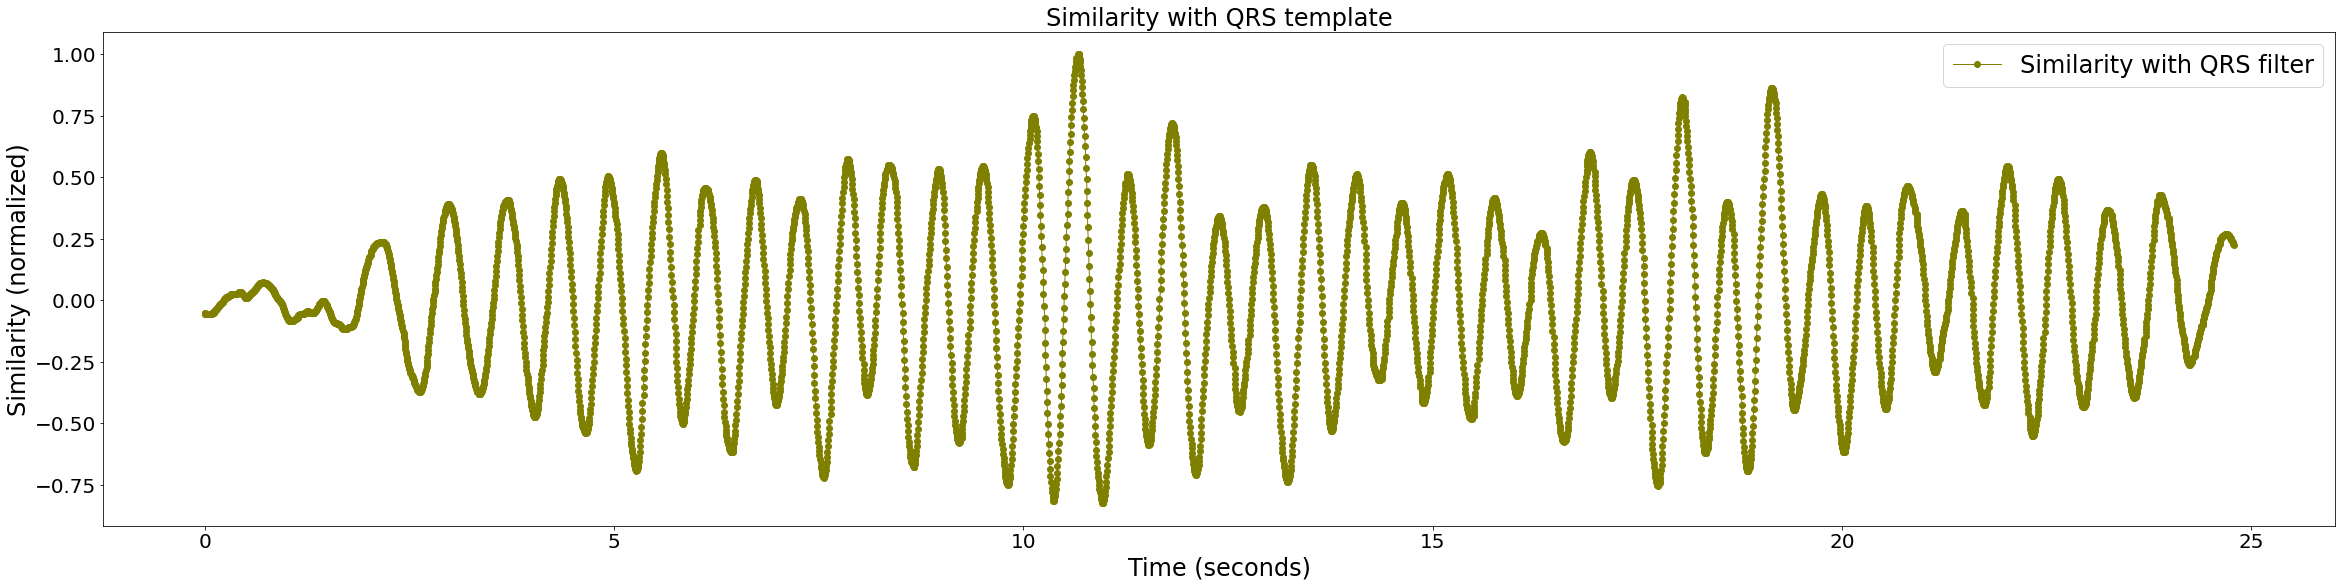

In [14]:
# plot similarity
plt.figure(figsize=(40, 20))
plt.subplot(211)
plt.title("Acceleration signal with found peaks", fontsize=24)
plt.plot(ecg_slice.index, ecg_slice, label="Moves", color="#51A6D8", linewidth=1, marker="o")
# EXPLANATION: np.repeat(1.4,peaks.shape[0]) creates an array of peaks.shape[0] elements and value 1.4 (amplitude)
plt.plot(peaks, np.repeat(1.4, peaks.shape[0]), markersize=10, label="peaks", color="orange", marker="o", linestyle="None")
plt.legend(loc="upper right", fontsize=24)
plt.xlabel("Time (seconds)", fontsize=24)
plt.ylabel("Amplitude (g's)", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
plt.figure(figsize=(40, 20))
plt.subplot(212)
plt.title('Similarity with QRS template', fontsize=24)
plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1, marker="o")
plt.legend(loc="upper right", fontsize=24)
plt.xlabel("Time (seconds)", fontsize=24)
plt.ylabel("Similarity (normalized)", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()